# **Media Prediction EDA**


All dataframes loaded can be constructed using data.ipynb

In [2]:
import pandas as pd
import ast
import os
DATA_DIR = '~/Desktop/code/data/'

## Taxonomy

### [1.1] MediaDive taxonomic diversity

In [3]:
md_df = pd.read_csv(os.path.join(DATA_DIR,"mediadive","mediadive-all.csv"), sep = ';')

import plotly.express as px

n = 50 #number of species we wanna show

# Plot the occurrence of enzymes across all of our selected taxa 
fig = px.bar(
    data_frame = md_df.value_counts('species').head(n).reset_index(),
    x="species",
    y="count",
    
    title="Species abundance in MediaDive (by strain count, top %i)" %n
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.show()

### [1.2] NCBI Trees

In [4]:
import ncbitaxonomist as nt
from Bio import Phylo
import pylab

taxa2ec = pd.read_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), low_memory=False)

tax_ids = taxa2ec['taxon_id'].to_list()
taxa = set(tax_ids)
taxa = list(taxa)

ncbi = {"ncbi_id": taxa}
ncbi_input = pd.DataFrame(ncbi).astype(str)

#ncbi_input.to_csv(os.path.join(DATA_DIR, "ncbi.txt"), index=False)

## Manual steps through NCBI to generate newick / other tree files: ##
#   Make tree file from NCBI ID input: https://www.ncbi.nlm.nih.gov/Taxonomy/CommonTree/wwwcmt.cgi
#   Turn the file into a viewable format: https://www.ncbi.nlm.nih.gov/projects/treeview/tv.html?appname=ncbi_tviewer&renderer=radial&openuploaddialog
#   Eventually replace with a python tree constructor or R

# Using this package all tree files must be in the working directory, can't call on filepaths for some reason

# "Pretty" tree -- too many labels make unreadable
#tree = Phylo.read("tree.nwk", "newick")
#tree.ladderize()  # Flip branches so deeper clades are displayed at top
#Phylo.draw(tree)

# Ascii scrollable tree
#tree = Phylo.read("tree.nwk", "newick")
#Phylo.draw_ascii(tree)
#pylab.show()

#tree = Phylo.read("genus2.nwk", "newick")
#Phylo.draw_ascii(tree)
#pylab.show()

## Enzymes

### [2.1] taxa2ec enzyme diversity

In [5]:
data = pd.read_csv(os.path.join(DATA_DIR, 'taxa2ec-final.csv'), low_memory=False)
ecs = data.copy()

# Summing the abundance of enzymes across our taxa related to different enzyme groups
enzyme_df = ecs.value_counts("ec").reset_index().copy() #ecs.value_counts originally
enzyme_df['Group'] = enzyme_df['ec'].apply(lambda x: x.strip().split('.')[0])
grouped_df = enzyme_df.groupby('Group')['count'].sum().reset_index()
grouped_df.columns = ['Group','Total Count']
# Adding information on the type of enzymes
ec_class = ['Oxidoreductases','Transferases','Hydrolases','Lyases','Isomerases','Ligases','Translocases']
grouped_df['Class'] = ec_class

taxa_enzyme_counts = grouped_df[['Group','Class','Total Count']]
print(taxa_enzyme_counts)

import plotly.express as px

# Plot the occurrence of enzymes across all of our selected taxa 
fig2 = px.bar(taxa_enzyme_counts, x="Class", y="Total Count")
fig2.show()


  Group            Class  Total Count
0     1  Oxidoreductases       250577
1     2     Transferases       512583
2     3       Hydrolases       462458
3     4           Lyases       146148
4     5       Isomerases        99566
5     6          Ligases       141588
6     7     Translocases        48603


### [2.2] media2ec enzyme diversity

In [6]:
data = pd.read_csv(os.path.join(DATA_DIR, 'media2ec-explode.csv'), low_memory=False)
ecs = data.copy()

# Summing the abundance of enzymes across our taxa related to different enzyme groups
enzyme_df = ecs.value_counts("ec_KEGG").reset_index().copy() #ecs.value_counts originally
enzyme_df['Group'] = enzyme_df["ec_KEGG"].apply(lambda x: x.strip().split('.')[0])
grouped_df = enzyme_df.groupby('Group')['count'].sum().reset_index()
grouped_df.columns = ['Group','Total Count']

# Create filler rows for classes which have 0 counts (manual step) ... no group 7 translocases in dataset
filler_dict = {'Group':[7], 'Total Count':[0]}
filler = pd.DataFrame(filler_dict)
grouped_df = pd.concat([grouped_df,filler], ignore_index = True).copy()
grouped_df['Group'] = grouped_df['Group'].astype(int)
grouped_df = grouped_df.sort_values('Group')
grouped_df.reset_index()

# Adding information on the type of enzymes
ec_class = ['Oxidoreductases','Transferases','Hydrolases','Lyases','Isomerases','Ligases','Translocases']
grouped_df['Class'] = ec_class

media_enzyme_counts = grouped_df[['Group','Class','Total Count']]
print(media_enzyme_counts)

import plotly.express as px

# Plot the occurrence of enzymes across all of our selected media 
fig3 = px.bar(media_enzyme_counts, x="Class", y="Total Count")
fig3.show()


   Group            Class  Total Count
0      1  Oxidoreductases        21718
1      2     Transferases         2995
2      3       Hydrolases         1110
3      4           Lyases           17
4      5       Isomerases            2
5      6          Ligases          358
6      7     Translocases            0


### [2.3] Comparison of enzyme diversity

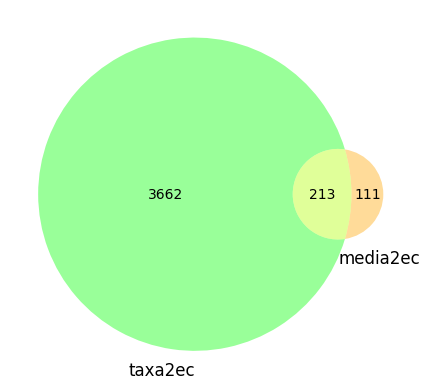

In [7]:
# Convert taxa2ec info to list
taxa2ec_df = pd.read_csv(os.path.join(DATA_DIR, 'taxa2ec-final.csv'), low_memory=False)
taxa2ec_list = taxa2ec_df['ec'].to_list()

# Convert kegg2ec info to list
media2ec_df = pd.read_csv(os.path.join(DATA_DIR, 'media2ec-explode.csv'), low_memory=False)
media2ec_list = media2ec_df['ec_KEGG'].to_list()

from matplotlib import pyplot as plt
from matplotlib_venn import venn2

venn2(
    subsets=[
        set(taxa2ec_list),
        set(media2ec_list)
    ],
    set_labels=[
        "taxa2ec",
        "media2ec"
    ],
    set_colors=[
        "lime",
        "orange"
    ]
)

In [8]:
# Make a list of the common ec's between these two lists
set1 = set(taxa2ec_list)
set2 = set(media2ec_list)
common = list(set1.intersection(set2))

# Put the list into a dataframe
dict = {'ec': common}
ecs = pd.DataFrame(dict)

# Summing the abundance of enzymes across our taxa related to different enzyme groups
enzyme_df = ecs.value_counts("ec").reset_index().copy() #ecs.value_counts originally
enzyme_df['Group'] = enzyme_df['ec'].apply(lambda x: x.strip().split('.')[0])
grouped_df = enzyme_df.groupby('Group')['count'].sum().reset_index()
grouped_df.columns = ['Group','Total Count']

# Create filler rows for classes which have 0 counts (manual step)
filler_dict = {'Group':[5,7], 'Total Count':[0,0]}
filler = pd.DataFrame(filler_dict)
grouped_df = pd.concat([grouped_df,filler], ignore_index = True).copy()
grouped_df['Group'] = grouped_df['Group'].astype(int)
grouped_df = grouped_df.sort_values('Group')
grouped_df.reset_index()

# Adding information on the type of enzymes (NOTE: no enzymes from class 5 or 7, so removed these labels...could alternatively have a place holder above)
ec_class = ['Oxidoreductases','Transferases','Hydrolases','Lyases','Isomerases','Ligases','Translocases']
grouped_df['Class'] = ec_class

enzyme_counts = grouped_df[['Group','Class','Total Count']]
print(enzyme_counts)

import plotly.express as px

# Plot the occurrence of enzymes across our overlapping dataset
fig4 = px.bar(enzyme_counts, x="Class", y="Total Count") #, title="Overlap of enzyme classes between taxa and media:"
fig4.show()

   Group            Class  Total Count
0      1  Oxidoreductases          141
1      2     Transferases           44
2      3       Hydrolases           22
3      4           Lyases            4
5      5       Isomerases            0
4      6          Ligases            2
6      7     Translocases            0


In [9]:
# Little bit of * code * to make my dreams come true
data = taxa2ec_df.copy()
filtered = data[data['ec'].isin(common)]
ns = data['ec'].str.contains("-")
filtered = filtered[~ns]

filtered.to_csv(os.path.join(DATA_DIR, "overlap.csv"), index=False)
filtered

C:\Users\jakel\AppData\Local\Temp\ipykernel_12916\4205329764.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,media_id,species,taxon_id,source,ec
0,1a,Comamonas testosteroni,1886637.0,uniprot,2.6.1.1
45,1a,Comamonas testosteroni,1886637.0,uniprot,1.2.1.10
46,1a,Comamonas testosteroni,1886637.0,uniprot,1.2.1.10
51,1a,Comamonas testosteroni,1886637.0,uniprot,1.2.1.10
61,1a,Delftia acidovorans,1871043.0,uniprot,2.4.2.1
...,...,...,...,...,...
1661485,J1270,Haemophilus influenzae,39482.0,bacdive,3.5.1.5
1661492,J1270,Haemophilus influenzae,39482.0,bacdive,3.2.1.22
1661506,J1270,Neisseria meningitidis,39486.0,bacdive,3.2.1.23
1661508,J1270,Neisseria meningitidis,39486.0,bacdive,3.5.1.5


### [2.4] Normalized barplots

In [10]:
# Dataframes to show enzyme class proportions relative to each dataset

df1 = taxa_enzyme_counts.copy() 
sum1 = df1['Total Count'].sum(axis=0)
df1['Taxa_Proportion'] = df1['Total Count'].div(sum1)

df2 = media_enzyme_counts.copy() 
sum2 = df2['Total Count'].sum(axis=0)
df2['Media_Proportion'] = df2['Total Count'].div(sum2)

df3 = enzyme_counts.copy() 
sum3 = df3['Total Count'].sum(axis=0)
df3['Overlap_Proportion'] = df3['Total Count'].div(sum3)


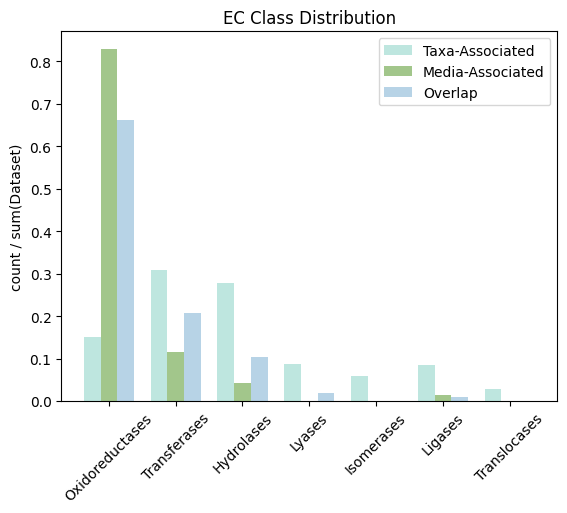

In [40]:
import numpy as np 
import matplotlib.pyplot as plt 
  
N = 7
ind = np.arange(N)  
width = 0.25
  
xvals = df1['Taxa_Proportion']
bar1 = plt.bar(ind, xvals, width, color = '#8DD3C790') 
  
yvals = df2['Media_Proportion']
bar2 = plt.bar(ind+width, yvals, width, color='#4D922185') 
  
zvals = df3['Overlap_Proportion']
bar3 = plt.bar(ind+width*2, zvals, width, color = '#80B1D390') 
   
plt.ylabel("count / sum(Dataset)") 
plt.title("EC Class Distribution") 
  
plt.xticks(ind+width,['Oxidoreductases','Transferases','Hydrolases','Lyases','Isomerases','Ligases','Translocases'],rotation=45) 
plt.legend((bar1, bar2, bar3), ('Taxa-Associated', 'Media-Associated', 'Overlap') ) 
plt.show() 

In [47]:
# Dataframes to show enzyme class proportions relative to each dataset

df1 = taxa_enzyme_counts.copy() 
sum1 = df1['Total Count'].sum(axis=0)
df1['Taxa_Proportion'] = df1['Total Count'].div(sum1)

df2 = media_enzyme_counts.copy() 
sum2 = df2['Total Count'].sum(axis=0)
df2['Media_Proportion'] = df2['Total Count'].div(sum2)

df3 = enzyme_counts.copy() 
sum3 = df3['Total Count'].sum(axis=0)
df3['Overlap_Proportion'] = df3['Total Count'].div(sum3)

In [48]:
df1["Set"] = "Taxa"
df2["Set"] = "Media"
df3["Set"] = "Overlap"

df1 = df1.rename(columns={"Taxa_Proportion": "Ratio"}).drop("Total Count", axis=1)
df2 = df2.rename(columns={"Media_Proportion": "Ratio"}).drop("Total Count", axis=1)
df3 = df3.rename(columns={"Overlap_Proportion": "Ratio"}).drop("Total Count", axis=1)

frames = df1, df2, df3
snsdf = pd.concat(frames)
snsdf

,Group,Class,Ratio,Set
0,1,Oxidoreductases,0.150812,Taxa
1,2,Transferases,0.308502,Taxa
2,3,Hydrolases,0.278334,Taxa
3,4,Lyases,0.087960,Taxa
4,5,Isomerases,0.059925,Taxa
5,6,Ligases,0.085216,Taxa
6,7,Translocases,0.029252,Taxa
0,1,Oxidoreductases,0.828931,Media
1,2,Transferases,0.114313,Media
2,3,Hydrolases,0.042366,Media


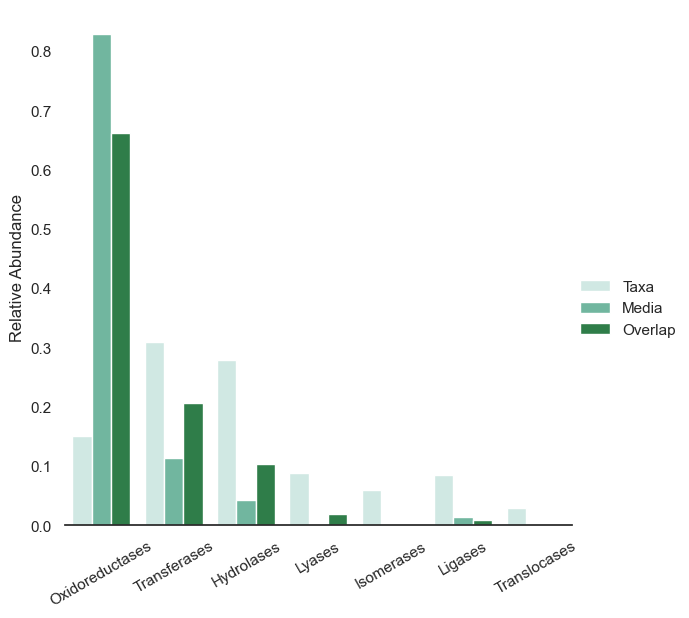

In [98]:
import seaborn as sns
sns.set_theme(style="white")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=snsdf, kind="bar",
    x="Class", y="Ratio", hue="Set",
    #errorbar="sd", 
    palette="BuGn", alpha=1, height=6
)

g.despine(left=True)
g.set_axis_labels("", "Relative Abundance")
g.tick_params(axis='x', rotation=30)

g.legend.set_title("")

In [12]:

#EC 1: Oxidoreductases – Enzymes that catalyze oxidation-reduction reactions.
#EC 2: Transferases – Enzymes that transfer a functional group (e.g., a methyl or phosphate group).
#EC 3: Hydrolases – Enzymes that catalyze the hydrolysis of various bonds.
#EC 4: Lyases – Enzymes that break various chemical bonds by means other than hydrolysis/oxidation, often forming a new double-bond or ring structure.
#EC 5: Isomerases – Enzymes that catalyze the transfer of groups within molecules to yield isomeric forms.
#EC 6: Ligases – Enzymes that join two molecules together, typically using ATP.
#EC 7: Translocases – Enzymes that catalyze the movement of ions or molecules across membranes or their separation within membranes.

### [2.5] Comparison of ec sources for taxa2ec

In [65]:
data = pd.read_csv("~/Desktop/code/premerg/data/taxa2ec-final.csv", low_memory=False) #update ... why were NCBI IDs lost?

substring1 = 'bacdive'
filter1 = data['source'].str.contains(substring1) # create filter
bacdive_df = data[filter1].copy()

substring2 = 'uniprot'
filter2 = data['source'].str.contains(substring2)
uniprot_df = data[filter2].copy()

substring3 = 'ncbi'
filter3 = data['source'].str.contains(substring3)
ncbi_df = data[filter3].copy()

from matplotlib import pyplot as plt
from matplotlib_venn import venn3



# BacDive incomplete parsing of ECs? Or really just that small of a dataset? (using set function removes duplicates)

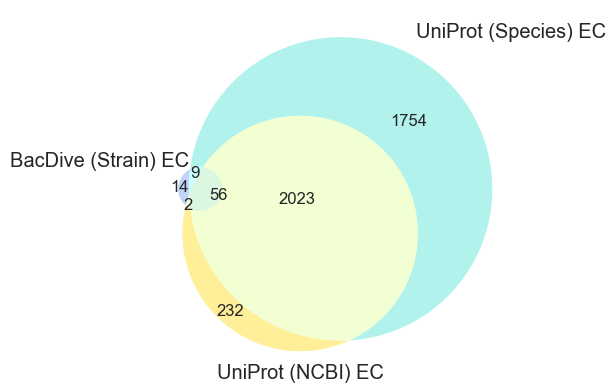

In [86]:
venn3(
    subsets=[
        set(bacdive_df["ec"]),
        set(uniprot_df["ec"]),
        set(ncbi_df["ec"])
    ],
    set_labels=[
        "BacDive (Strain) EC",
        "UniProt (Species) EC",
        "UniProt (NCBI) EC"
    ],
    set_colors=[
        "cornflowerblue",
        "turquoise",
        "gold"
    ]
)

### [2.6] Heatmap

In [14]:
data = pd.read_csv(os.path.join(DATA_DIR, 'taxa2ec-final.csv'), low_memory=False)

data_heatmap = data[["media_id", "taxon_id"]].drop_duplicates()
data_heatmap["count"] = 1
data_heatmap = data_heatmap.pivot(index="taxon_id", columns="media_id", values="count")

import plotly.express as px

#px.imshow(data_heatmap, width=1500, height=1500)

## Cofactors

### [3.1] ec2cofactors (taxa2ec)

In [15]:
# Load cofactor info and remove entries w/ non-specific EC numbers (i.e. 1.1.1.-, 1.1.-.-, etc.)
cofactors = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactors-taxa2ec.csv", low_memory=False)

substring = '-'
filter = cofactors['Query EC'].str.contains(substring)
cofactors = cofactors[~filter]

import plotly.express as px

data = cofactors.copy()
fig = px.bar(
    data_frame = data.value_counts("CofactorFinal").reset_index(),
    x="CofactorFinal",
    y="count",
    title="taxa2ec cofactors"
    #color="Class"
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.show()

### [3.2] ec2cofactors (media2ec)

In [16]:
# Load cofactor info and remove entries w/ non-specific EC numbers (i.e. 1.1.1.-, 1.1.-.-, etc.)
cofactors = cofactors = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactors-media2ec.csv", low_memory=False)

substring = '-'
filter = cofactors['Query EC'].str.contains(substring)
cofactors = cofactors[~filter]

import plotly.express as px

data = cofactors.copy()
fig = px.bar(
    data_frame = data.value_counts("CofactorFinal").reset_index(),
    x="CofactorFinal",
    y="count",
    title="media2ec cofactors"
    #color="Class"
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.show()

### [3.3] ec2cofactors (subset of isolates)

In [17]:
# Load cofactor info and remove entries w/ non-specific EC numbers (i.e. 1.1.1.-, 1.1.-.-, etc.)
cofactors = cofactors = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactors-subset.csv", low_memory=False)

substring = '-'
filter = cofactors['Query EC'].str.contains(substring)
cofactors = cofactors[~filter]

import plotly.express as px

data = cofactors.copy()
fig = px.bar(
    data_frame = data.value_counts("CofactorFinal").reset_index(),
    x="CofactorFinal",
    y="count",
    title="Isolate subset cofactors"
    #color="Class"
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.show()

### [3.4] Cofactor comparison (all)

In [18]:
# Load dataframes
taxa2ec = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactors-taxa2ec.csv", low_memory=False)
media2ec = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactors-media2ec.csv", low_memory=False)
subset = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactors-subset.csv", low_memory=False)

# Filter non-specific EC numbers
substring = '-'
filter1 = taxa2ec['Query EC'].str.contains(substring)
filter2 = media2ec['Query EC'].str.contains(substring)
filter3 = subset['Query EC'].str.contains(substring)

taxa2ec = taxa2ec[~filter1]
media2ec = media2ec[~filter2]
subset = subset[~filter3]

#Create, merge, format counts 
cf_df1 = taxa2ec["CofactorFinal"].value_counts().reset_index()
sum1 = cf_df1["count"].sum(axis=0)
cf_df1['Taxa_Proportion'] = cf_df1['count'].div(sum1)

cf_df2 = media2ec["CofactorFinal"].value_counts().reset_index()
sum2 = cf_df2["count"].sum(axis=0)
cf_df2['Media_Proportion'] = cf_df2['count'].div(sum2)

cf_df3 = subset["CofactorFinal"].value_counts().reset_index()
sum3 = cf_df3["count"].sum(axis=0)
cf_df3['Subset_Proportion'] = cf_df3['count'].div(sum3)

# Merging counts
cf_df1 = cf_df1.rename(columns={"count": "count1"})
cf_df2 = cf_df2.rename(columns={"count": "count2"})
cf_df3 = cf_df3.rename(columns={"count": "count3"})

cf_df = pd.merge(left=cf_df1, right=cf_df2, on="CofactorFinal", how="left")
cf_df = pd.merge(left=cf_df, right=cf_df3, on="CofactorFinal", how="left")
cf_df = cf_df.fillna(0)

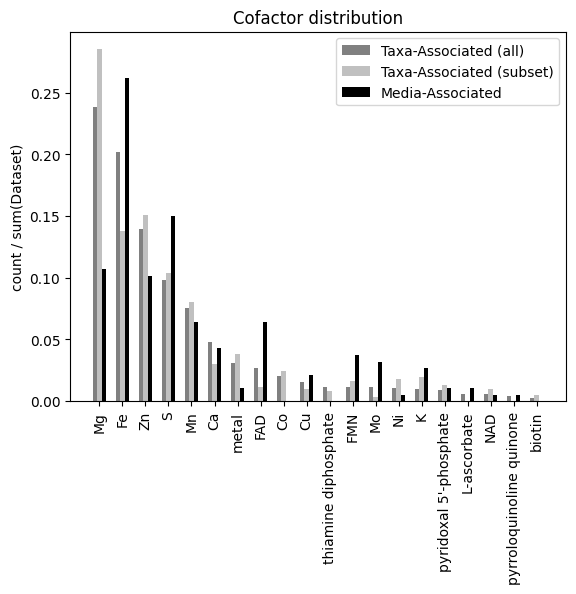

In [19]:
import numpy as np 
import matplotlib.pyplot as plt 

cf_df = cf_df.head(20) # Subset full dataframe; usual length is ~45 cofactors
N = 20

ind = np.arange(N)  
width = 0.2
  
xvals = cf_df['Taxa_Proportion']
bar1 = plt.bar(ind, xvals, width, color = 'grey') 
  
yvals = cf_df['Subset_Proportion']
bar2 = plt.bar(ind+width, yvals, width, color='silver') 
  
zvals = cf_df['Media_Proportion']
bar3 = plt.bar(ind+width*2, zvals, width, color = 'black') 
  
#plt.xlabel("Cofactor") 
plt.ylabel("count / sum(Dataset)") 
plt.title("Cofactor distribution") 
  
plt.xticks(ind+width,cf_df["CofactorFinal"],rotation=90) 
plt.legend( (bar1, bar2, bar3), ('Taxa-Associated (all)', 'Taxa-Associated (subset)', 'Media-Associated') ) 
plt.show() 

In [20]:
# Dataframe with all 'x'2ec numbers with associated cofactors, dropping duplicates
mc_df = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactors-grouped-media2ec.csv", low_memory=False)
tc_df = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactors-grouped-taxa2ec.csv", low_memory=False)
cofactors = [mc_df, tc_df]
cf_df = pd.concat(cofactors)
cf_df = cf_df.drop_duplicates()

# Filter non-specific ECs for now (1.-.-.-, 1.1.1.-, etc.)
mask = cf_df["Query EC"].str.contains("-")
cf_df = cf_df[~mask]

#cf_df.to_csv(os.path.join(DATA_DIR, "cofactors", "ec2cofactor-all.csv"), index=False)
cf_df.head()

,Query EC,CofactorFinal
2,1.1.1.1,"[Zn, Fe]"
3,1.1.1.103,[Zn]
4,1.1.1.14,[Zn]
5,1.1.1.2,[Zn]
6,1.1.1.23,"[Zn, pyridoxal 5'-phosphate]"


In [21]:
import plotly.express as px

data = cf_df.copy()
fig = px.bar(
    data_frame = data.value_counts("CofactorFinal").head(25).reset_index(),
    x="CofactorFinal",
    y="count",
    title="media2ec/taxa2ec cofactors (multiple => cambialistic)"
    #color="Class"
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.show()

In [22]:
cfmd = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactor-model-media.csv", low_memory=False)
cfmd.head()

import plotly.express as px

data = cfmd.copy()
data = data.drop_duplicates()

fig = px.bar(
    data_frame = data.value_counts("CofactorFinal").head(25).reset_index(),
    x="CofactorFinal",
    y="count",
    title="media2ec/taxa2ec cofactors"
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.show()

### [3.5] Cofactor comparison (metals)

In [23]:
metals_df = cf_df.copy()

# Subset with ONLY metal cofactors:
metals = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/metals-list.csv", low_memory=False)
metals_list = metals['Metals'].to_list()
mask = metals_df['CofactorFinal'].isin(metals_list)
metals_cf = metals_df[mask].reset_index()

metals_cf.head()

,index,Query EC,CofactorFinal


In [24]:
import numpy as np 
import matplotlib.pyplot as plt 

N = 14

ind = np.arange(N)  
width = 0.25
  
xvals = metals_cf['Taxa_Proportion']
bar1 = plt.bar(ind, xvals, width, color = 'grey') 
  
yvals = metals_cf['Subset_Proportion']
bar2 = plt.bar(ind+width, yvals, width, color='silver') 
  
zvals = metals_cf['Media_Proportion']
bar3 = plt.bar(ind+width*2, zvals, width, color = 'black') 
  
#plt.xlabel("Cofactor") 
plt.ylabel("count / sum(dataset_counts)") 
plt.title("Metal-Ion Cofactor Distribution") 
  
plt.xticks(ind+width,metals_cf["CofactorFinal"],rotation=0) 
plt.legend( (bar1, bar2, bar3), ('Taxa-Associated (all)', 'Taxa-Associated (subset)', 'Media-Associated') ) 
plt.show() 

KeyError: 'Taxa_Proportion'

## Metabolites

### [4.1] Metabolite Production

In [ ]:
df = pd.read_csv(os.path.join(DATA_DIR, "bacdive", "metabol_pro.csv"))

import plotly.express as px

n = 10 #number of entries we wanna show
N = len(df) #number of total entries

# Plot the occurrence of enzymes across all of our selected taxa 
fig = px.bar(
    data_frame = df.value_counts('metabolite').head(n).reset_index(), #
    x="metabolite",
    y="count",
    
    title="Metabolite production (top %i of %i entries)" % (n, N)
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.show()

In [ ]:
# Subset for thermophiles
df["isolation_info"] = df["isolation_info"].astype(str).dropna().copy()

# Remove "nan" which aren't removed with .dropna()
nan = df["isolation_info"].str.contains("nan")
thermophiles = df["isolation_info"].str.contains("thermal")
subset = df[thermophiles & ~nan]

import plotly.express as px

n = len(subset)

# Plot the occurrence of enzymes across all of our selected taxa 
fig = px.bar(
    data_frame = subset.value_counts('metabolite').reset_index(), 
    x="metabolite",
    y="count",
    
    title="Metabolite production (thermophile subset, %i entries total)" %n
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.show()

### [4.2] Metabolite utilization

In [ ]:
metabol_uti = pd.read_csv(os.path.join(DATA_DIR, "bacdive", "metabol_uti.csv"))

import plotly.express as px

n = 100
N = len(metabol_uti)

# Plot the occurrence of enzymes across all of our selected taxa 
fig = px.bar(
    data_frame = metabol_uti.value_counts('metabolite').head(n).reset_index(), 
    x="metabolite",
    y="count",
    
    title="Metabolite utilization (top %i of %i entries total)" % (n, N)
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.show()

### [4.3] Co-occurence of metabolites produced/utilized (potentially useful for predicting symbioses)

In [ ]:
# Load metabolite dataframes
utilization = pd.read_csv(os.path.join(DATA_DIR, "bacdive", "metabol_uti.csv"))
production = pd.read_csv(os.path.join(DATA_DIR, "bacdive", "metabol_pro.csv"))

# Make the metabolites produced into a set
mp_list = production["metabolite"].to_list()
mp_list = set(mp_list) #remove duplicates by turning into a set
mp_list = list(mp_list)

# Filter utilization for overlapping metabolites using mp_list
filter = utilization["metabolite"].isin(mp_list)
overlap = utilization[filter]

In [ ]:
import plotly.express as px

n = 10
N = len(overlap)

# Plot the occurrence of enzymes across all of our selected taxa 
fig = px.bar(
    data_frame = overlap.value_counts('metabolite').head(n).reset_index(), 
    x="metabolite",
    y="count",
    
    title="Production counts for overlapping metabolites (top %i of %i entries total)" % (n, N)
)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.show()

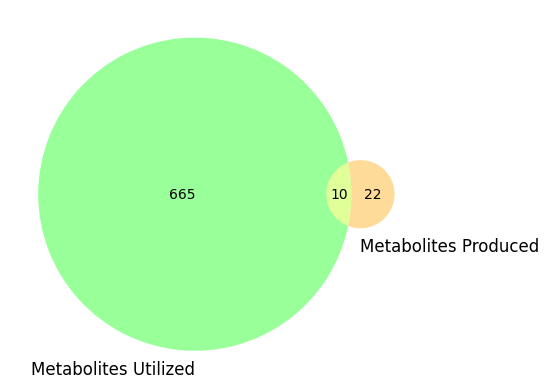

In [ ]:
list1 = utilization["metabolite"].to_list()
list2 = production["metabolite"].to_list()

from matplotlib import pyplot as plt
from matplotlib_venn import venn2

venn2(
    subsets=[
        set(list1),
        set(list2)
    ],
    set_labels=[
        "Metabolites Utilized",
        "Metabolites Produced"
    ],
    set_colors=[
        "lime",
        "orange"
    ]
)

### In general, the metabolite utilization information from BacDive is much more extensive than the metabolite production information

Subsetting metabolites based on isolate information

In [ ]:
utilization = pd.read_csv(os.path.join(DATA_DIR, "bacdive", "metabol_uti.csv"))
production = pd.read_csv(os.path.join(DATA_DIR, "bacdive", "metabol_pro.csv"))

def isolate_subset(df):
    df["isolation_info"] = df["isolation_info"].astype(str).dropna()
    nan = df["isolation_info"].str.contains("nan")
    isolates = df["isolation_info"].str.contains("thermal") ### REPLACE WITH SEARCH TERM ###
    result = df[isolates & ~nan]
    return result

uti_subset = isolate_subset(utilization)
pro_subset = isolate_subset(production)

# Make the metabolites produced into a list
metabolites = pro_subset["metabolite"].to_list()
mp_set = set(metabolites)
mp_list = list(mp_set)

# Filter utilization for overlapping metabolites using mp_list
filter = uti_subset["metabolite"].isin(mp_list)
subset = uti_subset[filter]
subset.head()

### Thermophiles appear to have no overlapping metabolites between production/utilization (incomplete info)

,bacdive_id,taxon_id,chebi_id,metabolite,utilization activity,kind of utilization tested,isolation_info
133131,164551,2530200,16136.0,hydrogen sulfide,-,assimilation,"[{'@ref': 67770, 'sample type': 'Gill of a shr..."


### [4.4] Miscellaneous Cofactor Figures

In [ ]:
data = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactor-model-media.csv", low_memory=False)

data_heatmap = data[["media_id", "CofactorFinal"]].drop_duplicates()
data_heatmap["count"] = 1
data_heatmap = data_heatmap.pivot(index="media_id", columns="CofactorFinal", values="count") #.pivot

import plotly.express as px
px.imshow(data_heatmap, width=1000, height=1000)

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



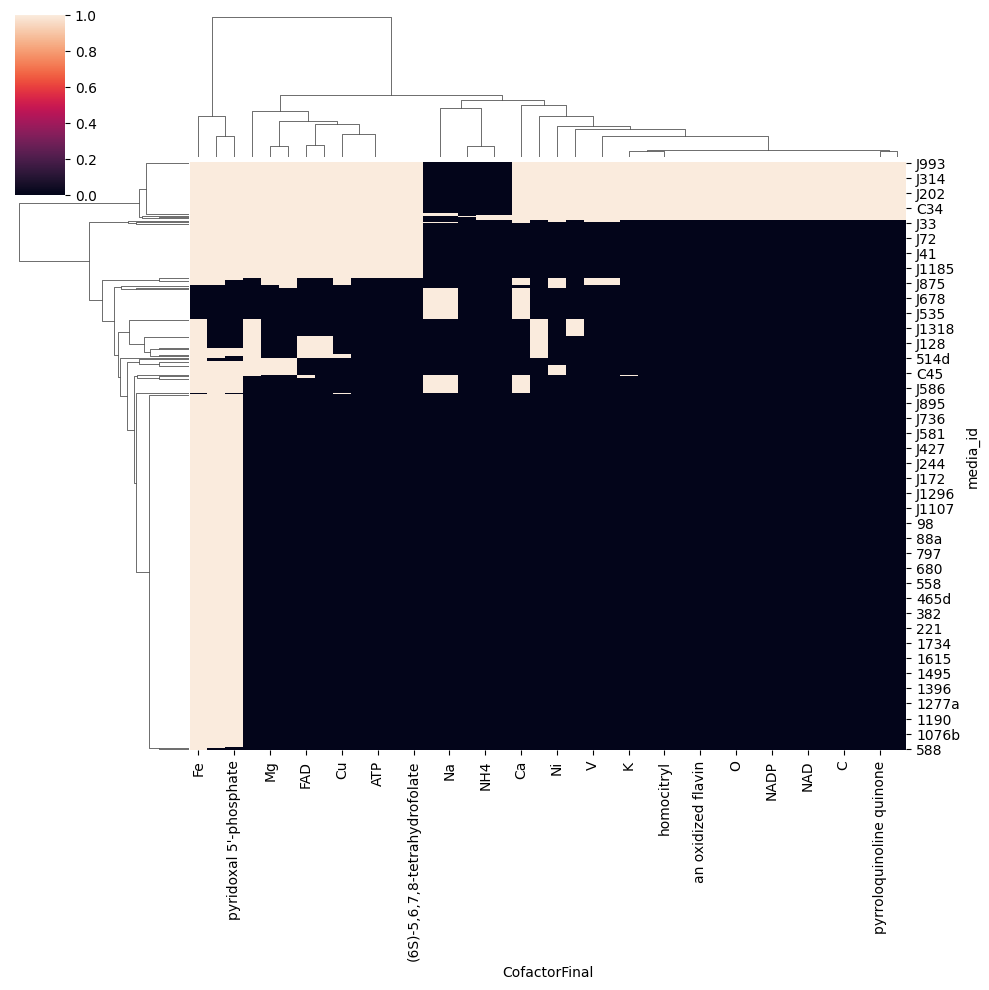

In [ ]:
import seaborn as sns

data = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactor-model-media.csv", low_memory=False)

data = data[["media_id", "CofactorFinal"]].drop_duplicates()
data["count"] = 1
data = pd.pivot_table(data, values='count', index='media_id', columns='CofactorFinal')
data = data.fillna(0)

# Create clustermap
sns.clustermap(data)

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



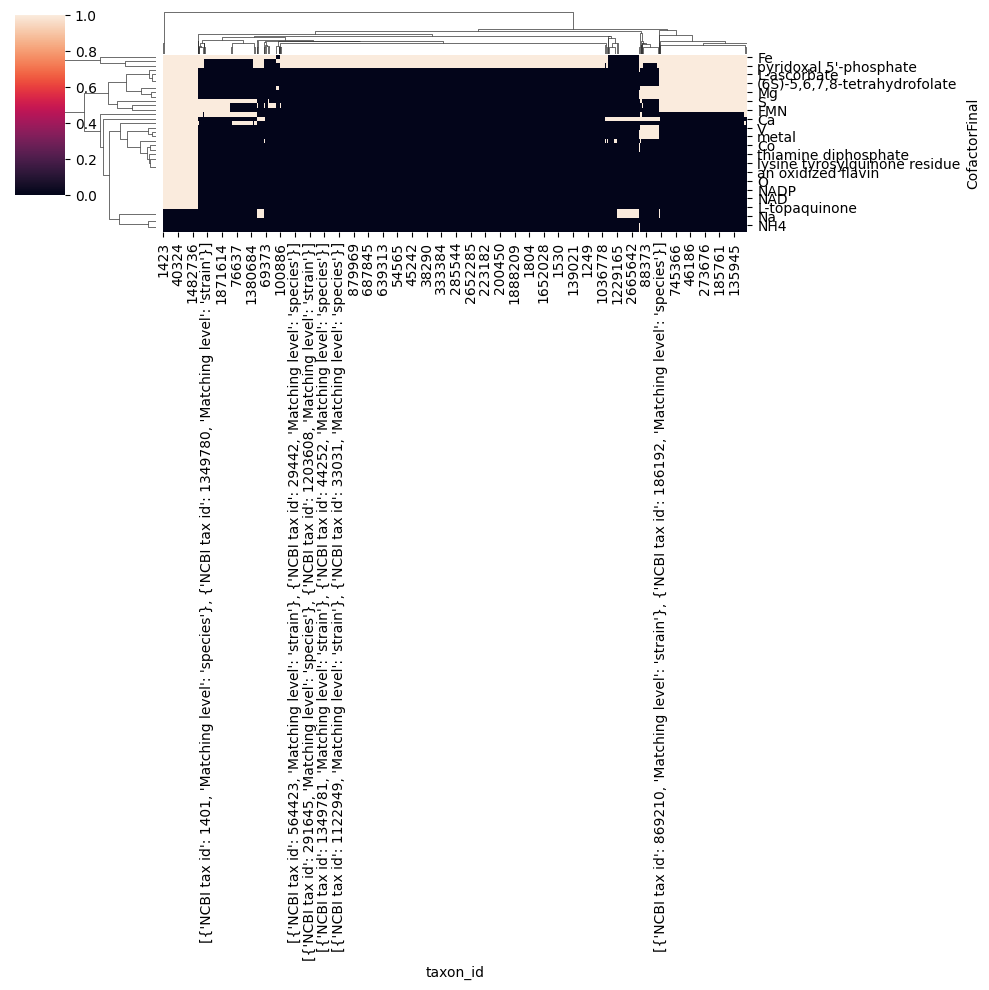

In [ ]:
data = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/cofactors/cofactor-model-media.csv", low_memory=False)

data = data[["taxon_id", "CofactorFinal"]].drop_duplicates()
data["count"] = 1
data = pd.pivot_table(data, values='count', index='CofactorFinal', columns='taxon_id')
data = data.fillna(0)

# Create clustermap
sns.clustermap(data)

## Model Comparison (reduced dataframes / clusters)

** old models, no longer relevant (UPDATE)

In [ ]:
t_ec = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/models/taxa-model.csv", low_memory=False)
tc = t_ec[["taxon_id", "media_id", "Cluster"]].astype(str)
m_ec = pd.read_csv("C:/Users/jakel/Desktop/code/premerg/data/models/media-model.csv", low_memory=False)
mc = m_ec[["taxon_id", "media_id", "Cluster"]].astype(str)

df = pd.merge(left=tc, right=mc, on="taxon_id")
df.head()


,taxon_id,media_id_x,Cluster_x,media_id_y,Cluster_y
0,28123,J84,2,J84,0
1,173363,J22,3,J22,0
2,"[{'NCBI tax id': 1218111, 'Matching level': 's...",J346,0,J739,2
3,411570,J14,2,J84,0
4,574718,J26,3,J26,0


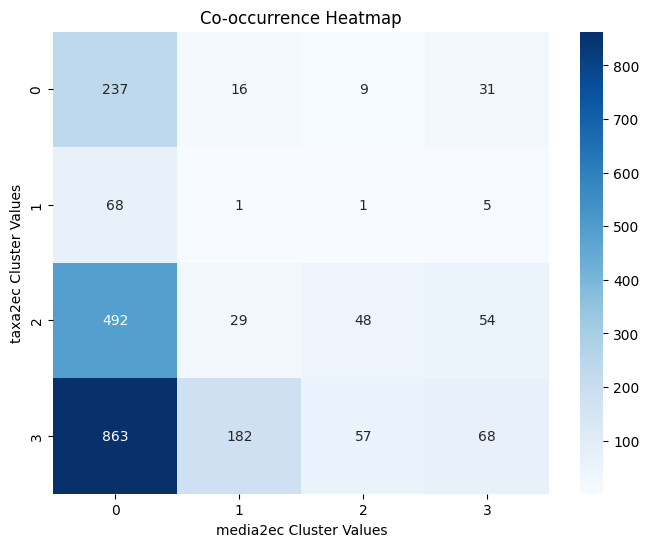

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the co-occurrence matrix
co_occurrence = pd.crosstab(df['Cluster_x'], df['Cluster_y'])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence, annot=True, cmap='Blues', fmt='d')
plt.title('Co-occurrence Heatmap')
plt.xlabel('media2ec Cluster Values')
plt.ylabel('taxa2ec Cluster Values')
plt.show()
